In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy

### Import LDA document vectors

In [3]:
#LDA = pickle.load(open("../processed_files/LDA_mat.pickle", "rb"))
lda_matrix = scipy.sparse.load_npz('../processed_files/lda_matrix.npz')
#lda_matrix = np.load('../processed_files/lda_matrix.npy', allow_pickle = True)
df_merged = pickle.load(open("../processed_files/df_merged.pickle", "rb"))

In [4]:
lda_matrix.shape

(12956, 20)

In [5]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED
0,0-my.com,0-my.com related searches: related searches:,"[mycom, related, searches, related, searches]","[mycom, relat, search, relat, search]"
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[error, page, cannot, display, pleas, contact,..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailable, purchase, wwwvcom, welcome, uu...","[com, vailabl, purchas, wwwvcom, welcom, uunic..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dnsir, ir, hits, construction, coming, so...","[ir, dnsir, ir, hit, construct, come, soon, ho..."
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[februari, onlin, market, review, search, rece..."


In [6]:
df_merged.shape

(12968, 4)

In [7]:
type(lda_matrix[0])

scipy.sparse.csr.csr_matrix

## lda

In [27]:
from sklearn.preprocessing import normalize
#lda_matrix = normalize(lda_matrix, norm='l2', axis=1)

In [28]:
%%time
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(lda_matrix)
distances, indices = nbrs.kneighbors(lda_matrix)

/Users/dkarsann/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/dkarsann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/dkarsann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, u

CPU times: user 4.38 s, sys: 1.41 s, total: 5.79 s
Wall time: 5.93 s


In [26]:
print(distances.shape)
print(indices.shape)

(12956, 20)
(12956, 20)


In [28]:
distances[80]

array([0.        , 0.01169061, 0.04375289, 0.0509878 , 0.0509878 ,
       0.0509878 , 0.0509878 , 0.0509878 , 0.0509878 , 0.0509878 ,
       0.0509878 , 0.0509878 , 0.0509878 , 0.0509878 , 0.0509878 ,
       0.0509878 , 0.0509878 , 0.0509878 , 0.0509878 , 0.0509878 ])

In [29]:
indices[80]

array([   80,  7065, 10952,  7020,  9849, 12470,  8551,  9839, 10545,
        9256,  3652, 12831,  1147,  4321,  9510,   893, 12357, 12404,
        8219, 12348])

In [56]:
import statistics

def intracluster_similarity(index):
    cluster_centroid = lda_matrix[index]
    dist_list = []
    for i in indices[index][1:]:
        val = cluster_centroid-lda_matrix[i]
        distance = np.linalg.norm(cluster_centroid.toarray()-lda_matrix[i].toarray())
        dist_list.append(distance)
        #print(index, ',', i, '=', distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)
    
    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    #print('variance:', variance)
    
    return avg, variance

In [57]:
intracluster_similarity(51)

(0.10513576424000623, 0.0012109843799752516)

In [32]:
def generate_raw_content_cluster_df(index):
    index_list = list(indices[index])
    distance_list = list(distances[index])
    cluster_seed = df_merged.loc[index].to_frame().T
    cluster_seed['DISTANCE'] = 0
    cluster_df = df_merged.loc[index_list[1:]]
    cluster_df['DISTANCE'] = distance_list[1:]
    combined = pd.concat([cluster_seed, cluster_df.sort_values(by='DISTANCE', ascending=True)])
    return combined.style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})
    #return combined

In [36]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic e
generate_raw_content_cluster_df(80)

In [92]:
avg_list = []
variance_list = []

for i in range(lda_matrix.shape[0]):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x13708feb8>,
 <a list of 11 Text xticklabel objects>)

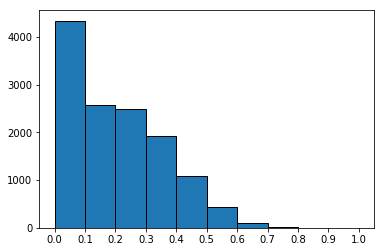

In [84]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x139230d30>,
 <a list of 11 Text xticklabel objects>)

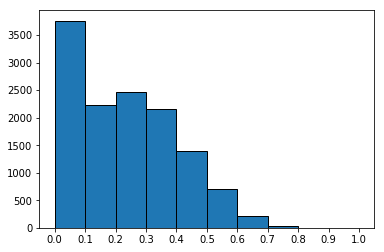

In [65]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x1376560f0>,
 <a list of 11 Text xticklabel objects>)

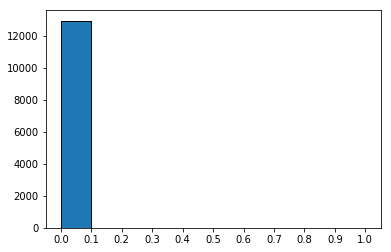

In [85]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x135c07320>,
 <a list of 11 Text xticklabel objects>)

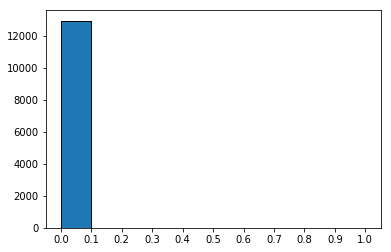

In [66]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [67]:
print(len(avg_list), len(variance_list))

12956 12956


## Intercluster Similarity

In [68]:
def calculate_centroid(index):
    cluster_centroid = lda_matrix[index]
    for i in indices[index][1:]:
        cluster_centroid = np.add(cluster_centroid, lda_matrix[i])
    return cluster_centroid/len(indices[index][1:])

In [93]:
index_centroid = dict()
for i in range(lda_matrix.shape[0]):
    index_centroid[i] = calculate_centroid(i)

In [70]:
index_centroid[0]

<1x20 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [24]:
#centroid_centroid_distance = {}
#for i in range(lda_matrix.shape[0]):
#    centroid_centroid_distance[i] = {}
#    for j in range(lda_matrix.shape[0]):
#        if i < j:
#            centroid_centroid_distance[i][j] = np.linalg.norm(index_centroid[i]-index_centroid[j])

In [25]:
#centroid_centroid_distance

In [75]:
from random import sample
def sample_mean_intercluster_dist(sample_size):
    indices_sample = sample(range(lda_matrix.shape[0]),sample_size)
    centroid_centroid_distance = {}
    for i in indices_sample:
        for j in indices_sample:
            if i < j:
                key = str(i) + "::" + str(j)
                centroid_centroid_distance[key] = np.linalg.norm(index_centroid[i].toarray()-index_centroid[j].toarray())
    return np.array(list(centroid_centroid_distance.values())).mean()

# neighbors = 10

## 10 documents sample

In [94]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[1.0464213530389224, 1.1395159724712505, 0.9327915360656446, 0.9201479532489377, 1.056167486011462]

1.0190088601672436


## 100 documents sample

In [95]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[1.0273323917074864, 1.018740892771914, 1.0274383319021272, 0.9728724163148011, 0.9688460669605504]

1.0030460199313758


## 500 documents sample

In [96]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[1.000711197585989, 1.0017444958711215, 1.0021407923916097, 1.0086956985611117, 0.9966409764563173]

1.0019866321732298


# neighbors = 20

## 10 documents sample

In [79]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[1.230783270725787, 1.3208423461832042, 1.2617280002518556, 1.1932949197561769, 1.3726498037761299]

1.2758596681386307


## 100 documents sample

In [80]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[1.3176038893055697, 1.296724448818587, 1.307074326968726, 1.3076248669607657, 1.2923292679934881]

1.3042713600094273


## 500 documents sample

In [81]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[1.3026997794770985, 1.2998331381229966, 1.2950098885835564, 1.308393421153768, 1.3002901804786517]

1.3012452815632143
